# OsuLearn
##### Machine Learning para jogar mapas de osu!

^^^

Isso aí, tô sem mais nada pra fazer, bora criar uma IA que joga osu! )o)

## Importar umas coisas...

In [1]:
# Machine Learning
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt

# Utilidades
import os
import math

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constantes

Aqui tem uns caminhos para os arquivos que precisamos:

In [2]:
# Pasta do osu!
OSU_FOLDER = "C:\\" + os.path.join("Program Files (x86)", "Jogos", "osu!")

# Nome do beatmap
BEATMAP = os.path.join('499478 Utsu-P - TRAUMATIC', 'Utsu-P - TRAUMATIC (Cryptic) [EXTREME].osu')
#BEATMAP = os.path.join('353412 Sakuzyo - Imprinting', 'Sakuzyo - Imprinting (Necroluttah) [Arles AR9.5].osu')

# Nome do arquivo de replay
REPLAY = 'BzMasked - Utsu-P - TRAUMATIC [EXTREME] (2018-12-17) Osu.osr'
#REPLAY = 'BzMasked - Sakuzyo - Imprinting [Arles AR9.5] (2018-12-17) Osu.osr'

## Leitura do arquivo de Beatmap

O formato do arquivo está especificado no [site do osu!](https://osu.ppy.sh/help/wiki/osu!_File_Formats/Osu_(file_format)/).

In [3]:
import osu.beatmap

beatmap_filename = os.path.join(OSU_FOLDER, "Songs", BEATMAP)
beatmap = osu.beatmap.load(beatmap_filename)

print()
print('Mapa:', beatmap['ArtistUnicode'], '-', beatmap['TitleUnicode'])
print('Autor:', beatmap['Creator'])
print('Dificuldade: ', beatmap['Version'])


Mapa: 鬱P - TRAUMATIC
Autor: Cryptic
Dificuldade:  EXTREME


## Leitura do arquivo de Replay

O formato do arquivo está especificado no [site do osu!](https://osu.ppy.sh/help/wiki/osu!_File_Formats/Osr_(file_format)/).

In [4]:
# replay = osu.replay.load(os.path.join(OSU_FOLDER, "Replays", REPLAY))

## Informações do Replay

Legal, carregamos o replay, isso foi o que achamos:

In [5]:
# print()
# print("Player:", replay.player)

# print()
# print("Pontuação Total:", replay.score)
# print()
# print("%5d x 300\t%5d x 激" % (replay.n_300s, replay.n_geki))
# print("%5d x 100\t%5d x 喝" % (replay.n_100s, replay.n_katu))
# print("%5d x 50\t%5d x Erros" % (replay.n_50s, replay.n_misses))
# print()

# print("Acurácia: %.2f%%" % (100 * replay.accuracy))
# print("Combo Máximo: %dx" % replay.max_combo, "(Perfect)" if replay.perfect else "")
# print()

# %matplotlib inline

# u = [int(t[0]) / 1000 for t in replay.life_graph]
# v = [float(t[1]) for t in replay.life_graph]

# fig = plt.figure(facecolor='#333333')
# ax = fig.add_subplot(1, 1, 1)
# ax.set_xlim(0, max(u) + 1)
# ax.set_ylim(0, 1.1)
# ax.axis('off')
# ax.plot(u, v, '#ffcc22')
# plt.show()

## Visualização

Aqui temos uma previsualização do replay, também:

In [6]:
%matplotlib notebook
#osu.replay.preview(beatmap, replay)

## Dados para treinamento...

In [7]:
import osu.replay
import re

from glob import glob

replay_training_set = []

pattern = os.path.join(OSU_FOLDER, "Replays", "* Osu.osr")
for replay_file in glob(pattern):
    info = re.search(r"([^\\/]+) \- (.+ \- .+) \[(.+)\] \((.+)\)", replay_file)
    player, bmap, diff, date = info[1], info[2], info[3], info[4]
    print(player, bmap, diff, date)
    
    fpat = os.path.join(OSU_FOLDER, "Songs", "*" + bmap + "*", "*[[]" + diff + "[]].osu")
    
    for beatmap_file in glob(fpat):
        beatmap = osu.beatmap.load(beatmap_file)
        if re.search("v14", beatmap.format_version) != None:
            replay = osu.replay.load(replay_file)
            if len(replay.data) < 10000 and not (replay.mods & 0x10 or replay.mods & 0x40):
                replay_training_set.append([beatmap, replay])
                print("OK")
        else:
            print("Wrong format version")
            
    print()
    

BzMasked (K)NoW_NAME - Freesia Expert 2018-12-30
OK

BzMasked 55x55 - MRAZ' (feat. Larin) Insane 2018-12-30

BzMasked Aimer with chelly (EGOIST) - ninelie (REDSHiFT x Vesuvia remix) Daydream 2018-06-01

BzMasked Aitsuki Nakuru - Monochrome Butterfly Extra 2017-09-09
OK

BzMasked Aitsuki Nakuru - Monochrome Butterfly Mysterious 2017-08-04

BzMasked Alex Gaudino feat. Crystal Waters - Destination Calabria Destination Unknown 2017-11-25

BzMasked Alex Gaudino feat. Crystal Waters - Destination Calabria Destination Unknown 2017-12-01

BzMasked Asterisk - Ren-chon no Drum 'n' Bass Extra 2018-12-30
OK

BzMasked Ata - Euphoria Juggernaut 285bpm Tap jumps 2017-09-24
OK

BzMasked Ayase Rie - Yuima-ruWorld TVver. Ultimate 2017-08-14

BzMasked Camellia - Exit This Earth's Atomosphere Evolution 2017-08-13

BzMasked Camellia - Exit This Earth's Atomosphere Evolution 2018-09-27

BzMasked Caravan Palace - Lone Digger Funky 2018-09-28

BzMasked Celldweller - Weaponized AWM 2018-12-30
OK

BzMasked Chit

## Finalmente: Modelo de rede neural

Agora começa a festa...

In [8]:
from osu.learn.OsuLearnModel import create_training_data, create_target_data
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, CuDNNLSTM, concatenate, Input, Reshape, Conv1D, UpSampling1D

REPLAY_FEATURES = ['x', 'y']
MAP_FEATURES = ['x', 'y', 'time_left', 'is_slider', 'is_spinner']

X = create_training_data(replay_training_set)
y = create_target_data(replay_training_set)

print(X.shape, y.shape)

(27, 9955, 5) (27, 9955, 2)


In [16]:
model = Sequential()

map_input = Input(shape=(X.shape[1], X.shape[2]), name='map_info')

out = CuDNNLSTM(len(MAP_FEATURES), return_sequences=True)(map_input)
out = Conv1D(512, X.shape[1], activation='linear')(out)
out = Dropout(0.1)(out)

out = Dense(256, activation='linear')(out)
out = Dropout(0.2)(out)

out = Dense(X.shape[1] * len(REPLAY_FEATURES), activation='linear')(out)
out = Dropout(0.1)(out)

out = Reshape([X.shape[1], len(REPLAY_FEATURES)])(out)

model = Model(inputs=map_input, outputs=out)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
map_info (InputLayer)        (None, 9955, 5)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 9955, 5)           240       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 512)            25485312  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 256)            131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 19910)          5116870   
__________

In [10]:
def plot_info(compare):
    %matplotlib inline
    
    for data in compare:
        plt.plot([(x) for x, y in data])
    plt.show()
    
    for data in compare:
        plt.plot([(y) for x, y in data])
    plt.show()
    
#     for data in compare:
#         plt.plot([(a) for distance, angle in data])
#     plt.show()
    
#     for data in compare:
#         plt.plot([(b) for distance, angle in data])
    plt.show()

In [22]:
from random import randint
from sklearn.model_selection import train_test_split

model.load_weights("model.hdf5")

for _ in range(4):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=randint(0, 100))
    history = model.fit(X_train, y_train, batch_size=len(X_train), epochs=48)

model.save_weights("model.hdf5")

Epoch 1/48
18/18 [==============================] - 1s 33ms/step - loss: 0.0019 - acc: 0.7928
Epoch 2/48
18/18 [==============================] - 1s 32ms/step - loss: 0.0016 - acc: 0.8017
Epoch 3/48
18/18 [==============================] - 1s 33ms/step - loss: 0.0013 - acc: 0.8013
Epoch 4/48
18/18 [==============================] - 1s 33ms/step - loss: 0.0011 - acc: 0.8082
Epoch 5/48
18/18 [==============================] - 1s 33ms/step - loss: 9.5487e-04 - acc: 0.8038
Epoch 6/48
18/18 [==============================] - 1s 32ms/step - loss: 9.5525e-04 - acc: 0.7986
Epoch 7/48
18/18 [==============================] - 1s 33ms/step - loss: 0.0010 - acc: 0.8003
Epoch 8/48
18/18 [==============================] - 1s 33ms/step - loss: 0.0012 - acc: 0.8011
Epoch 9/48
18/18 [==============================] - 1s 33ms/step - loss: 9.5269e-04 - acc: 0.7967
Epoch 10/48
18/18 [==============================] - 1s 34ms/step - loss: 0.0011 - acc: 0.7983
Epoch 11/48
18/18 [============================

Epoch 37/48
18/18 [==============================] - 1s 32ms/step - loss: 7.4840e-04 - acc: 0.7738
Epoch 38/48
18/18 [==============================] - 1s 33ms/step - loss: 7.2814e-04 - acc: 0.7750
Epoch 39/48
18/18 [==============================] - 1s 32ms/step - loss: 7.2107e-04 - acc: 0.7740
Epoch 40/48
18/18 [==============================] - 1s 34ms/step - loss: 7.0761e-04 - acc: 0.7693
Epoch 41/48
18/18 [==============================] - 1s 32ms/step - loss: 7.0238e-04 - acc: 0.7713
Epoch 42/48
18/18 [==============================] - 1s 33ms/step - loss: 6.9019e-04 - acc: 0.7746
Epoch 43/48
18/18 [==============================] - 1s 34ms/step - loss: 9.0447e-04 - acc: 0.7691
Epoch 44/48
18/18 [==============================] - 1s 33ms/step - loss: 7.3243e-04 - acc: 0.7707
Epoch 45/48
18/18 [==============================] - 1s 33ms/step - loss: 5.9538e-04 - acc: 0.7806
Epoch 46/48
18/18 [==============================] - 1s 33ms/step - loss: 7.8680e-04 - acc: 0.7694
Epoch 47/4

Epoch 25/48
18/18 [==============================] - 1s 33ms/step - loss: 9.5821e-04 - acc: 0.7658
Epoch 26/48
18/18 [==============================] - 1s 33ms/step - loss: 9.1505e-04 - acc: 0.7598
Epoch 27/48
18/18 [==============================] - 1s 33ms/step - loss: 8.3487e-04 - acc: 0.7613
Epoch 28/48
18/18 [==============================] - 1s 33ms/step - loss: 9.1144e-04 - acc: 0.7526
Epoch 29/48
18/18 [==============================] - 1s 33ms/step - loss: 8.1703e-04 - acc: 0.7658
Epoch 30/48
18/18 [==============================] - 1s 34ms/step - loss: 7.3070e-04 - acc: 0.7754
Epoch 31/48
18/18 [==============================] - 1s 32ms/step - loss: 8.3327e-04 - acc: 0.7674
Epoch 32/48
18/18 [==============================] - 1s 33ms/step - loss: 7.0587e-04 - acc: 0.7657
Epoch 33/48
18/18 [==============================] - 1s 33ms/step - loss: 8.1938e-04 - acc: 0.7786
Epoch 34/48
18/18 [==============================] - 1s 33ms/step - loss: 8.3005e-04 - acc: 0.7683
Epoch 35/4

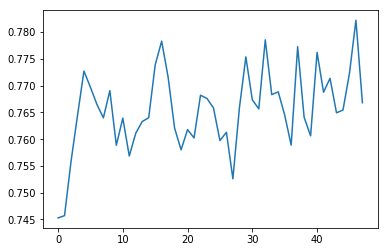

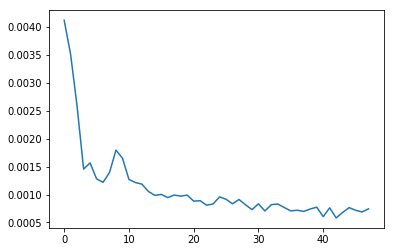

In [23]:
%matplotlib inline

plt.plot(history.history['acc'])
plt.show()

plt.plot(history.history['loss'])
plt.show()

0


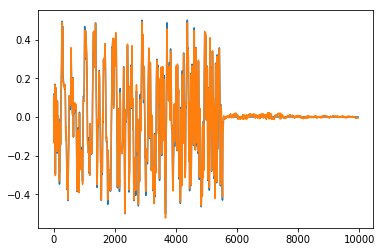

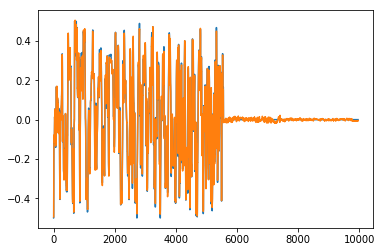

1


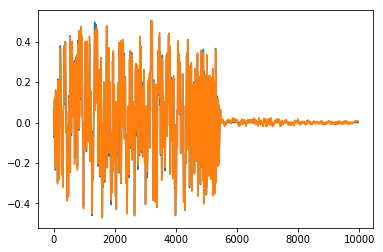

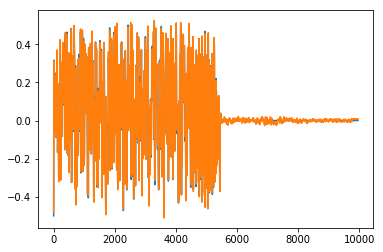

2


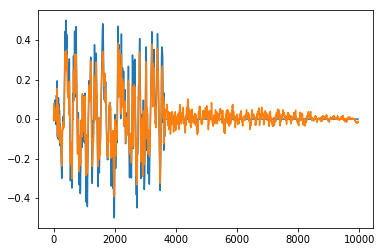

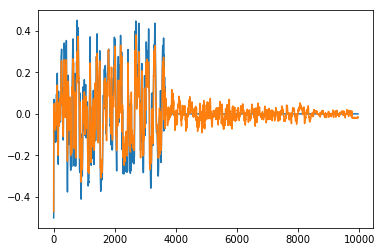

3


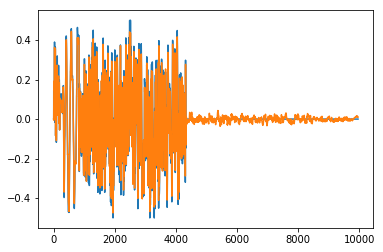

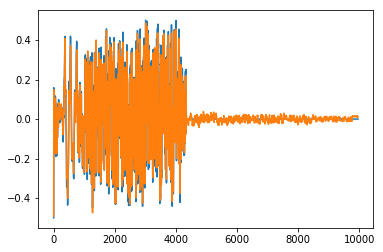

4


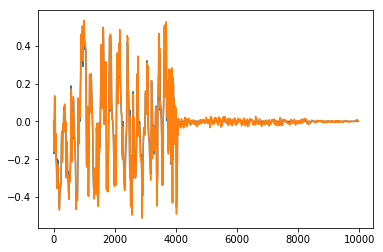

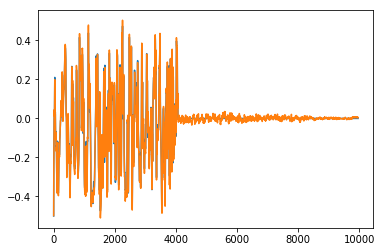

5


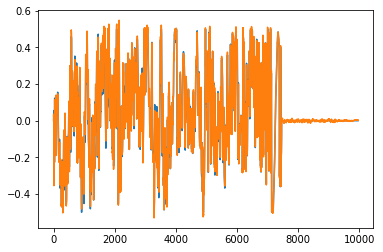

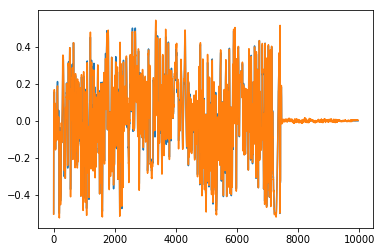

6


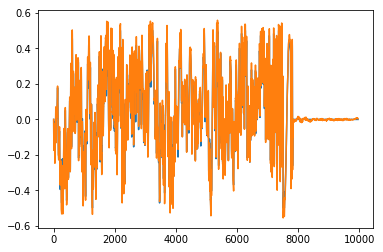

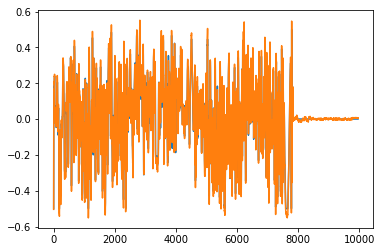

7


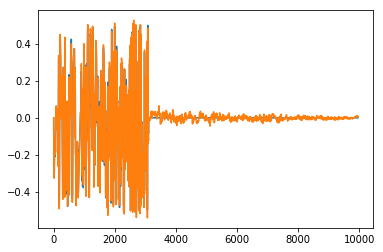

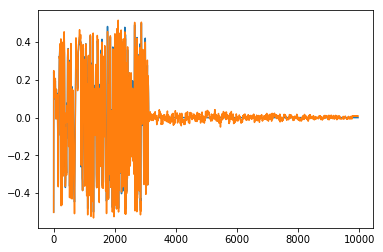

8


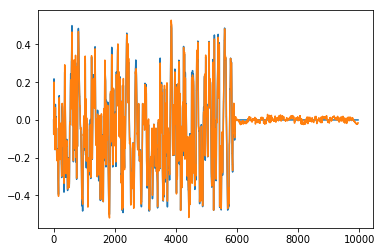

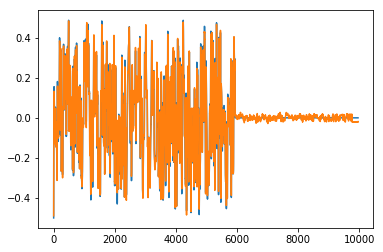

9


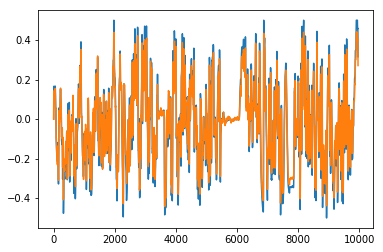

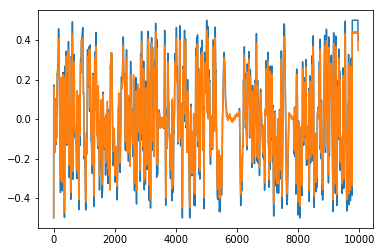

10


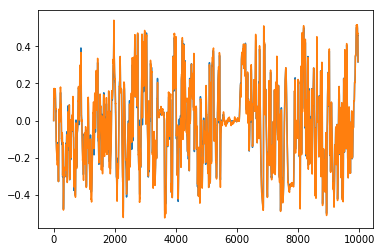

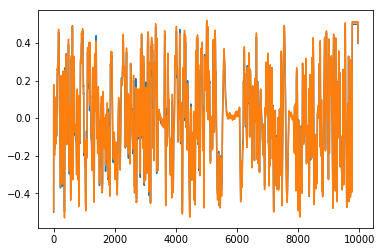

11


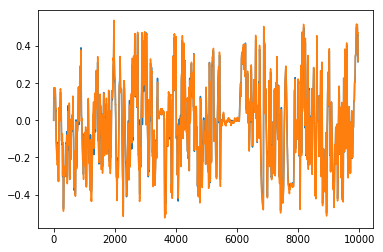

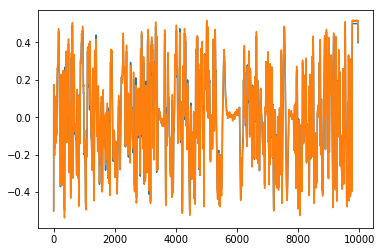

12


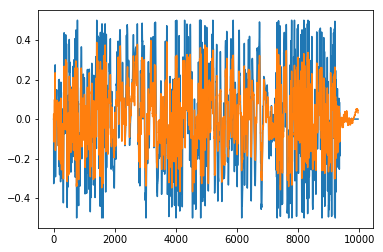

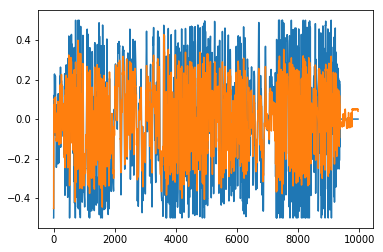

13


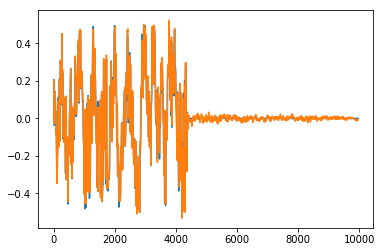

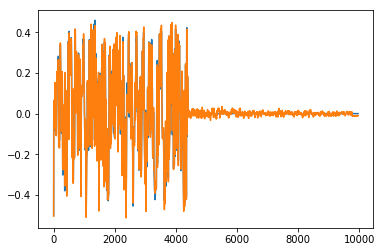

14


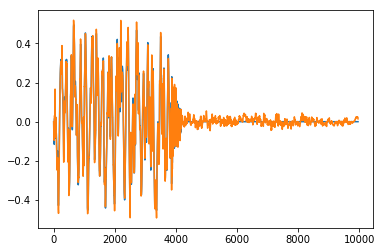

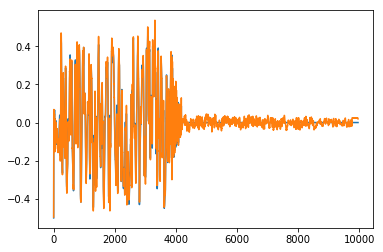

15


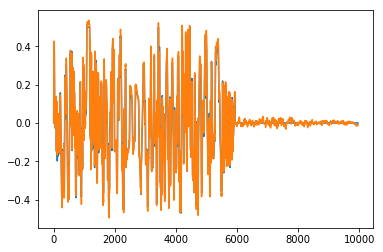

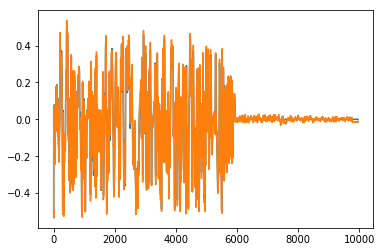

16


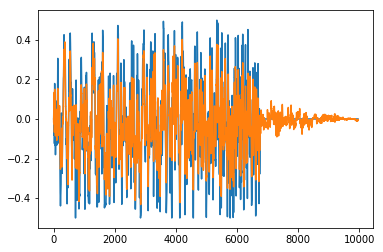

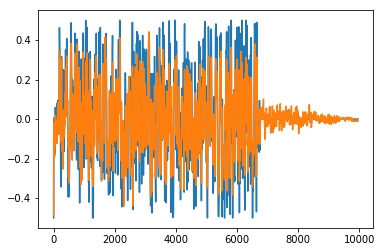

17


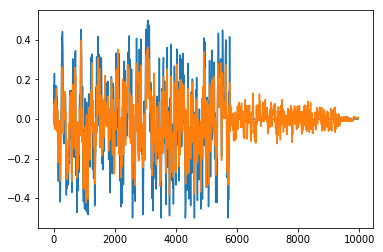

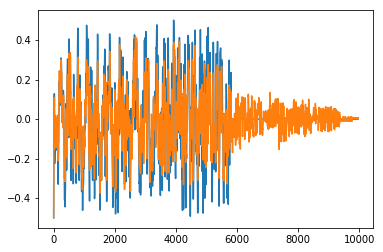

18


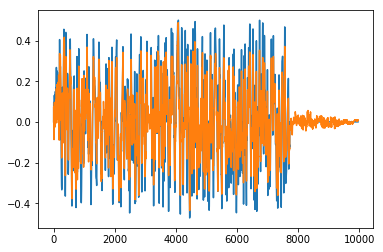

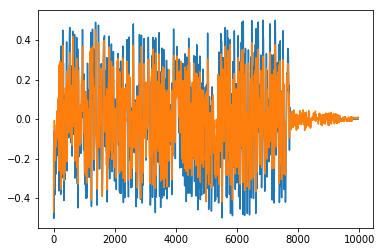

19


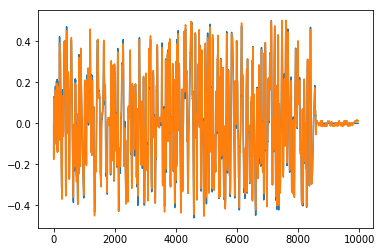

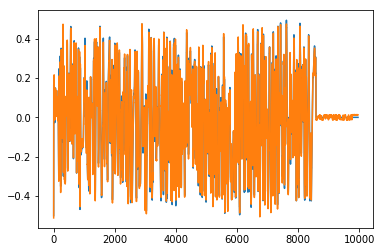

20


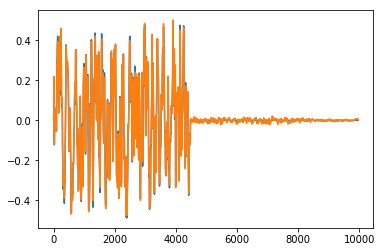

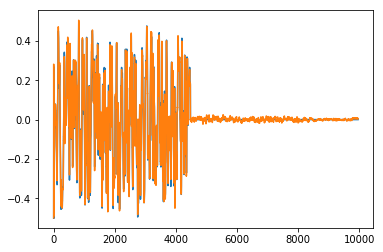

21


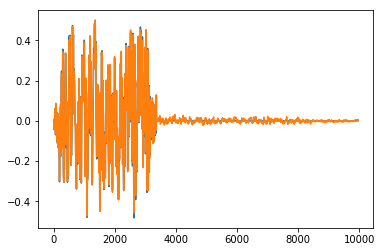

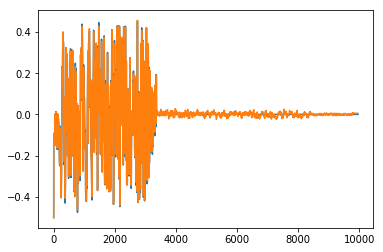

22


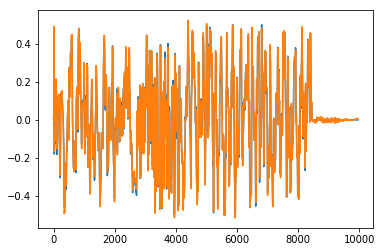

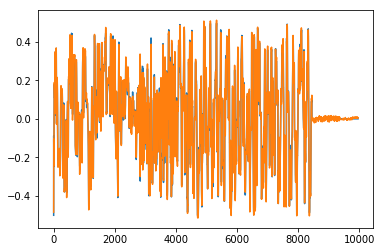

23


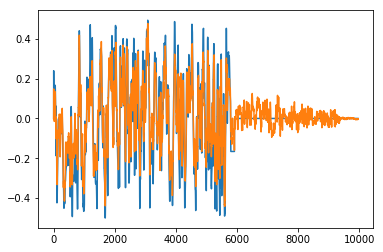

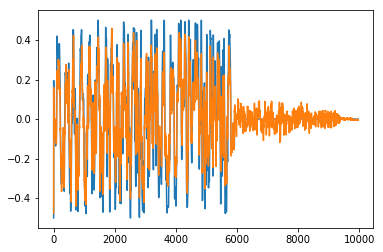

24


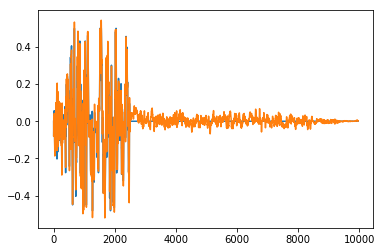

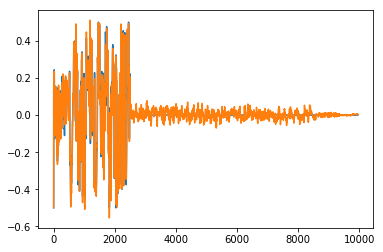

25


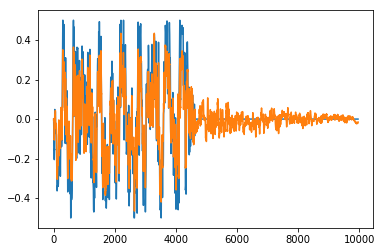

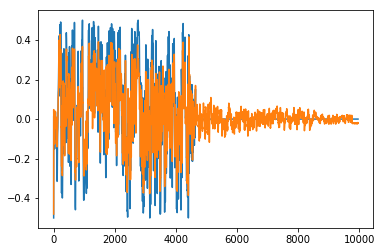

26


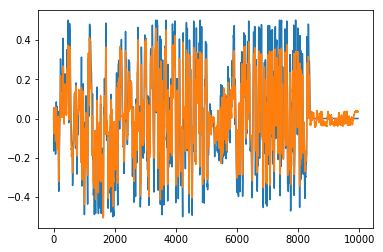

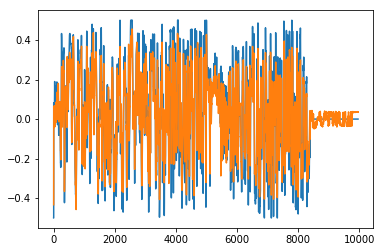

In [24]:
predicted = model.predict(X)

for i in range(len(predicted)):
    print(i)
    plot_info([y[i], predicted[i]])

<IPython.core.display.Javascript object>


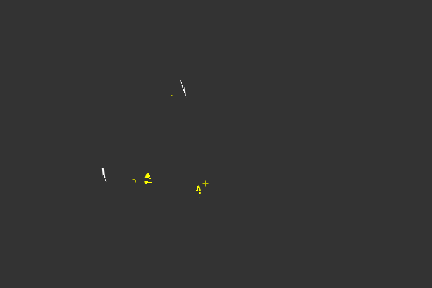

<IPython.core.display.Javascript object>


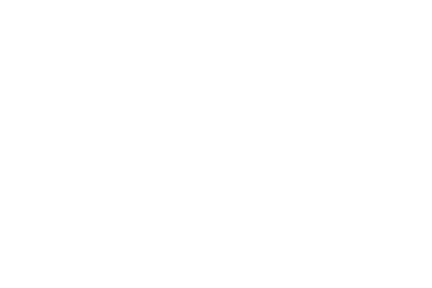

In [25]:
%matplotlib notebook

replay_data = []

n = 19

j = 0
for i in range(len(predicted[n])):
    if len(replay_training_set[n][1].data) > i + j:
        w = replay_training_set[n][1].data[i + j][0]
        while w < 0 and len(replay_training_set[n][1].data) > i + j + 1:
            j += 1
            w = replay_training_set[n][1].data[i + j][0]
    else:
        w = 0
        
    cx, cy = predicted[n][i]
    replay_data.append([w, cx * 512 + 256, cy * 384 + 192, 0])
    
osu.replay.preview(replay_training_set[n][0], replay_data)
#osu.replay.preview(replay_training_set[n][0], replay_training_set[n][1].data)